In [1]:
from __future__ import annotations

import io
import struct
import datetime
import numpy as np

In [2]:
HEADER_SIZE = 1159544
METADATA_SIZE = 554
SV_SCAN_SIZE = 25920
VOC_SCAN_SIZE = 17280
BB_SCAN_SIZE = 8640
TRANSPORT_BLOCK_SIZE = 9216
KM_DATA_SIZE = 2304

SYNCHROSERIES_SIZE = 10

SENSORS_COUNT = 40

# Colibrators
SV_BLOCK_SIZE = 216
SV_DN_INLINE_COUNT = 144

VOC_BLOCK_SIZE = 144
VOC_DN_INLINE_COUNT = 96

BB_BLOCK_SIZE = 72
BB_DN_INLINE_COUNT = 48

In [68]:
class Fy3eHeader:
    def __init__(self, data: bytes) -> None:
        self.__data = data

    @property
    def satellite_name(self) -> str:
        return self.__data[4:8].decode('utf-8')
    
    @property
    def instrumentation(self) -> str:
        return self.__data[12:17].decode('utf-8') # Под пиво (Влад сказал)
    
    # Вот тут будут datetime

    @property
    def scan_start(self) -> str: # datetime
        return self.__data[33:47].decode('utf-8')
    
    @property
    def scan_end(self) -> str: # datetime
        return self.__data[48:62].decode('utf-8')
    
    @property
    def l0_date_creation(self) -> str: # datetime
        return self.__data[63:77].decode('utf-8')

In [69]:
class Fy3eMetadata:
    def __init__(self, data: bytes) -> None:
        self.__data = data

In [70]:
class Fy3eDnData:
    def __init__(self, type: bytes, data: list[int]) -> None:
        self.type = type
        self.data = data

In [71]:
class Fy3eTransportBlock:
    def __init__(self, metadata: Fy3eMetadata, dn_data_blocks: list[list[Fy3eDnData]]) -> None:
        self.metadata = metadata
        self.dn_data_blocks = dn_data_blocks
        

In [72]:
class Fy3eFile:
    def __init__(self, header: Fy3eHeader, transport_blocks: list[Fy3eTransportBlock]) -> None:
        self.__header = header
        self.__transport_blocks = transport_blocks

    @property
    def header(self) -> Fy3eHeader:
        return self.__header

In [73]:
def read_uint12(data: bytes) -> list[int]:
    if len(data) % 3 != 0:
        raise ValueError()
    
    byte_array = []
    for i in range(0, len(data), 3):
        fst_uint8 = data[i + 0]
        mid_uint8 = data[i + 1]
        lst_uint8 = data[i + 2]

        fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
        snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8

        byte_array.append(fst_uint12)
        byte_array.append(snd_uint12)

    return byte_array

In [74]:
def parse(stream: io.BufferedIOBase) -> Fy3eFile:
    data = stream.read(HEADER_SIZE)
    header = Fy3eHeader(data)

    transport_blocks = []
    while True:
        data = stream.read(METADATA_SIZE)
        
        if len(data) != METADATA_SIZE:
            break

        metadata = Fy3eMetadata(data)

        type = stream.read(SYNCHROSERIES_SIZE)
        data = stream.read(SV_SCAN_SIZE)
        data = read_uint12(data)
        sv_scanlines = [Fy3eDnData(type, data)]

        type = stream.read(SYNCHROSERIES_SIZE)
        data = stream.read(VOC_SCAN_SIZE)
        data = read_uint12(data)
        voc_scanlines = [Fy3eDnData(type, data)]

        type = stream.read(SYNCHROSERIES_SIZE)
        data = stream.read(BB_SCAN_SIZE)
        data = read_uint12(data)
        bb_scanlines = [Fy3eDnData(type, data)]

        dn_11_scanline = []
        for _ in range(SENSORS_COUNT):
            type = stream.read(SYNCHROSERIES_SIZE)
            data = stream.read(TRANSPORT_BLOCK_SIZE)
            data = read_uint12(data)
            dn_11_sensor = Fy3eDnData(type, data)
            dn_11_scanline.append(dn_11_sensor)
        
        dn_12_scanline = []
        for _ in range(SENSORS_COUNT):
            type = stream.read(SYNCHROSERIES_SIZE)
            data = stream.read(TRANSPORT_BLOCK_SIZE)
            data = read_uint12(data)
            dn_12_sensor = Fy3eDnData(type, data)
            dn_12_scanline.append(dn_12_sensor)

        dn_1km_scanline = [] 
        for _ in range(SENSORS_COUNT):
            type = stream.read(SYNCHROSERIES_SIZE)
            data = stream.read(TRANSPORT_BLOCK_SIZE)
            data = read_uint12(data)
            dn_1km_sensor = Fy3eDnData(type, data)
            dn_1km_scanline.append(dn_1km_sensor)

        transport_block = Fy3eTransportBlock(metadata, [sv_scanlines, voc_scanlines, bb_scanlines, dn_11_scanline, dn_12_scanline, dn_1km_scanline])
        transport_blocks.append(transport_block)

    return Fy3eFile(header, transport_blocks)

In [75]:
with open('data/Y3E_08897_230323231257_7860R_MERSI.DAT', 'rb') as file:
    obama = parse(file)

In [80]:
obama.header.instrumentation

'MERSI'

In [11]:
dn_11_lines = []
for tb in obama.transport_blocks:
    dn_11_lines.extend([i.data for i in tb.dn_data_blocks[3]])

In [58]:
import matplotlib.pyplot as plt

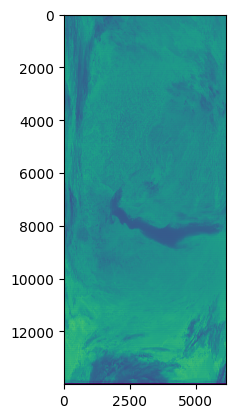

In [65]:
plt.imshow(dn_11_lines)